# Design Sensitivities Demo using DoMINO

In this notebook, we provide a self-contained demo of how to compute design sensitivities (i.e., how a functional of the solution varies with respect to the input geometry) using DoMINO.

First, we set up necessary imports and load the DoMINO configuration file, which defines various hyperparameters:

In [1]:
import torch
from pathlib import Path
import hydra
from omegaconf import DictConfig
import numpy as np
import pyvista as pv

from main import DoMINOInference
from physicsnemo.distributed import DistributedManager

torch.cuda.set_per_process_memory_fraction(0.99)

In [2]:
with hydra.initialize(version_base="1.3", config_path="./conf"):
    cfg: DictConfig = hydra.compose(config_name="config")

Next, we set up DistributedManager, which can be used for multi-GPU inference.

In [3]:
DistributedManager.initialize()
dist = DistributedManager()

if dist.world_size > 1:
    torch.distributed.barrier()  # ty: ignore[possibly-unbound-attribute]

/home/psharpe/GitHub/physicsnemo/physicsnemo/distributed/manager.py:415: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


Here, we set up DoMINOInference, which is the main inference-time interface to the DoMINO model. It provides a `__call__` method, which will be used to run the model.

As part of this, we accept a checkpoint path argument, which is used to load model parameters from training.

In [4]:
domino = DoMINOInference(
    cfg=cfg,
    model_checkpoint_path="./DoMINO.0.41.pt",
    dist=dist,
)

We then load the STL file from the `geometries` directory, which provides the input geometry for the simulation.

In [5]:
from utilities.download import download

input_file = Path(".")/"geometries"/"drivaer_1.stl"

download(
    url="https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_1/drivaer_1.stl",
    filename=input_file,
)

Skipping download, file already exists: geometries/drivaer_1.stl


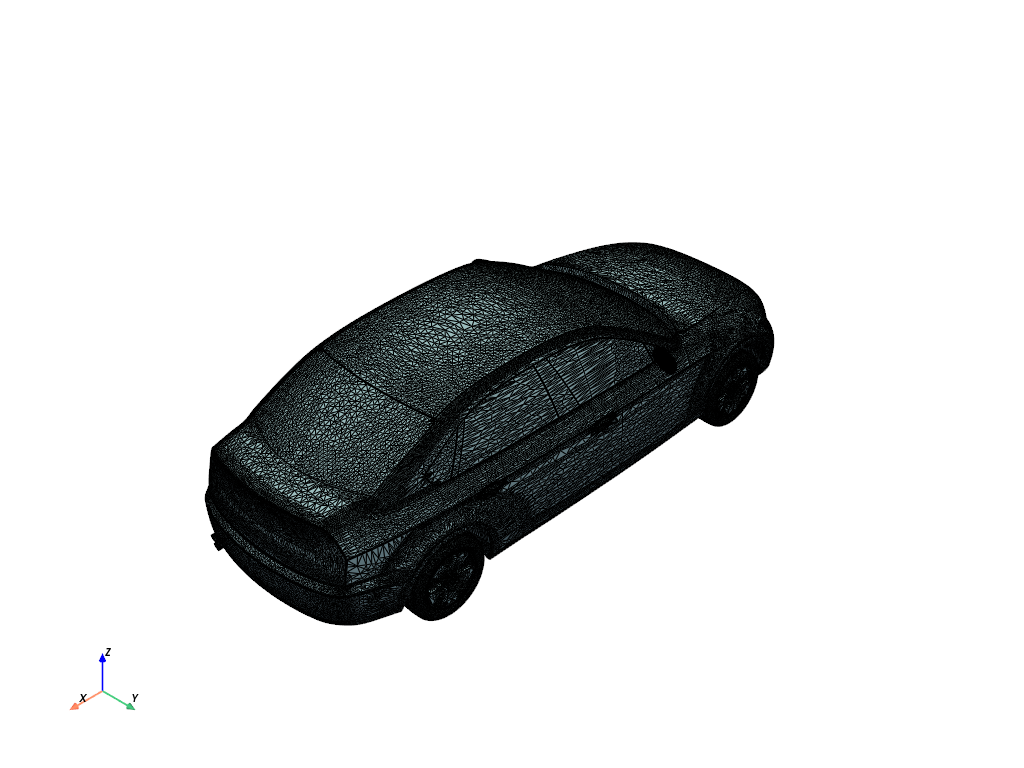

PolyData,Information
N Cells,753234
N Points,376531
N Strips,0
X Bounds,"-7.652e-01, 3.938e+00"
Y Bounds,"-1.010e+00, 1.010e+00"
Z Bounds,"-3.196e-01, 1.195e+00"
N Arrays,0


In [6]:
mesh: pv.PolyData = pv.read(input_file)  # ty: ignore[invalid-assignment]
mesh.plot(show_edges=True, jupyter_backend="static")
mesh

Next, we evaluate the aerodynamic flow around the geometry using the pre-trained DoMINO model. For models with the given hyperparameters, this may take 1-2 minutes to run, depending on hardware.

For memory efficiency and cache locality, points are evaluated in batches automatically.

The result of the model is a dictionary of NumPy arrays, including a "raw_sensitivities" key. For this example, these raw sensitivities are a `n_points x 3` array, where the ith row corresponds to the derivative of `-1 * total_drag_force` with respect to the ith point's position. In other words, the ith row represents the direction (and relative magnitude) that each point on the mesh should be moved to reduce drag.

The fact that this sensitivity is taken with respect to drag is current hardcoded in `main.py` for simplicity of this demo, and this can be modified for other cases as desired - this demo should be considered a template for other cases. For example, one could modify this workflow to compute sensitivities with respect to lift, a pressure drop, a target temperature value at some point, etc., depending on the case and physics at hand.

In [7]:
results: dict[str, np.ndarray] = domino(
    mesh=mesh,
    stream_velocity=38.889,  # m/s
    stencil_size=7,
    air_density=1.205,  # kg/m^3
    verbose=True,
)
results

Processing batches: 100%|██████████| 92/92 [27:53<00:00, 18.19s/it]


{'geometry_coordinates': array([[0.73355335, 0.75327766, 0.7155967 ],
        [0.713039  , 0.75503933, 0.703275  ],
        [0.75335604, 0.7515413 , 0.7288307 ],
        ...,
        [2.9238267 , 0.7700497 , 0.04187237],
        [2.92059   , 0.7700497 , 0.03719   ],
        [2.92716   , 0.7700497 , 0.0459795 ]], dtype=float32),
 'geometry_sensitivity': array([[-0.01056023, -0.04039691,  0.03318958],
        [-0.017409  , -0.0498447 ,  0.04639603],
        [-0.03873153, -0.08817464,  0.07833848],
        ...,
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]], dtype=float32),
 'pred_surf_pressure': array([ 17.164564,  52.357895,  15.829809, ..., 335.3714  , 292.00095 ,
        210.8641  ], dtype=float32),
 'pred_surf_wall_shear_stress': array([[-0.9828601 , -0.47572345,  0.4410524 ],
        [-0.8924766 , -0.49077788,  0.4100364 ],
        [-0.8333799 , -0.42780048,  0.43554404],
        ...,

The raw sensitivity values are interesting on their own, but they can be made more useful and interpretable with some postprocessing. In postprocessing, we fix two issues:

- First, while the raw sensitivity results have physically-meaningful signal, they are relatively noisy from cell-to-cell. This is expected here, due to model nonsmoothness. This same noise is also observed in adjoint sensitivity CFD workflows, which are the closest analogue of this design sensitivities workflow from traditional CFD. (In those cases, this is due to nonsmoothness of discretization and truncation errors.) With this traditional workflow, practitioners often apply a smoothing operation to the sensitivity results to aid in interpretation - we do the same here.
    - Notably, *even if we had a perfect model*, it would be a good idea to smooth the sensitivity results before using them to update the geometry (i.e., design optimization). This is because an unconstrained optimizer will inevitably manipulate geometry at the smallest physical scale it is allowed to, which is almost never physically-realizable when manufacturing a practical geometry. For more details on why this is, including applied examples, see [Mark Drela's "Pros and Cons of Airfoil Optimization"](https://web.mit.edu/drela/OldFiles/Public/papers/Pros_Cons_Airfoil_Optimization.pdf).
- Secondly, the raw sensitivity results are a 3D vector representing a direction that each point should be deformed. However, first-principles PDE analysis tells us that moving a point in-surface should not change the resulting solution - this follows from the definition of numerical consistency. In other words, any meaningful surface sensitivity information must be surface-normal. While this is already approximately true in the raw sensitivity results, errors in the model cause this to be slightly violated. Therefore, we project the sensitivity results onto the surface normal to yield more physically-meaningful results.

The postprocessed sensitivity results are stored in the `mesh` object, and can be plotted to visualize the sensitivity information.

In [8]:
for key, value in results.items():
    if len(value) == mesh.n_cells:
        mesh.cell_data[key] = value
    elif len(value) == mesh.n_points:
        mesh.point_data[key] = value

sensitivity_results: dict[str, np.ndarray] = domino.postprocess_point_sensitivities(
    results=results, mesh=mesh
)

for key, value in sensitivity_results.items():
    mesh[key] = value

mesh

Laplacian smoothing: 100%|██████████| 20/20 [00:01<00:00, 16.21it/s]


PolyData (0x7debcc16fe80)
  N Cells:    753234
  N Points:   376531
  N Strips:   0
  X Bounds:   -7.652e-01, 3.938e+00
  Y Bounds:   -1.010e+00, 1.010e+00
  Z Bounds:   -3.196e-01, 1.195e+00
  N Arrays:   10

## Visualization

We can visualize some of the sensitivity results here.

In the results below:

- A red region indicates that adding material here (i.e., pushing this surface outwards) would give lower total drag.
- A blue region indicates that removing material here (i.e., pulling this surface inwards) would give lower total drag.

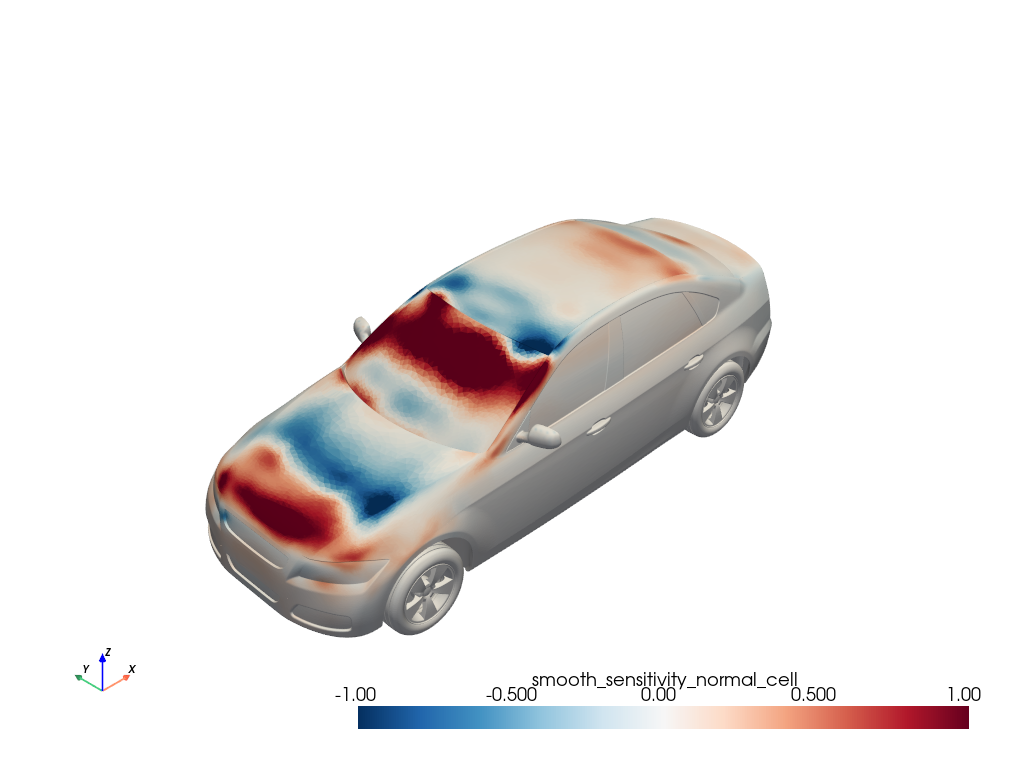

In [9]:
kwargs = dict(
    cmap="RdBu_r",
    jupyter_backend="static",
    cpos=[-1, -1, 1],
    clim=(-1, 1),
)

mesh.plot(scalars="smooth_sensitivity_normal_cell", **kwargs)

Finally, we can deform the geometry by these results. Note, however, that the sensitivity results are only valid for an infinitesimal deformation, and if the model itself is smooth. Hence, while this demo serves as an interesting proof-of-concept, more fundamental research into model architectures that incorporates smoothness considerations is needed before deploying this in a design optimization workflow.

Similarly below, the scale of such a deformation is massively exaggerated for visualization purposes.

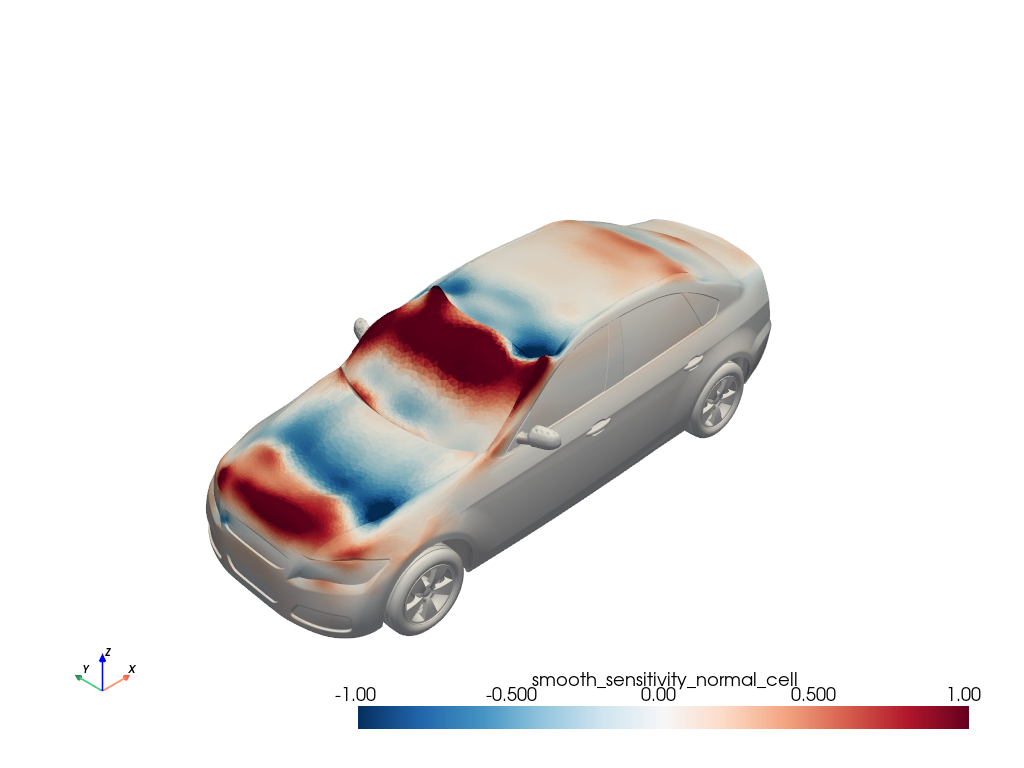

In [10]:
warped_geometry = mesh.warp_by_scalar("smooth_sensitivity_normal_point", factor=0.05)
warped_geometry.plot(scalars="smooth_sensitivity_normal_cell", **kwargs)

And, this resulting geometry (or the warped geometry) can be saved to disk:

In [11]:
mesh.save(input_file.with_suffix(".vtk"))